<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Моделирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.



Вам нужно:

1. За тестовую выборку взять последние 10% данных 
2. Построить модель для предсказания количества заказов такси на следущий час
3. Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.ar_model import AutoReg
import statsmodels.tsa.api as smt

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime']).sort_index()
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


В стоблце `num_orders` находится количество заказов за каждый час.  
Данные уже готовы для дальшейшей обработки.

Определяем тестовую выборку

In [5]:
test_limit = int(len(df)*.9)

In [6]:
test_limit

3974

Анализируем данные

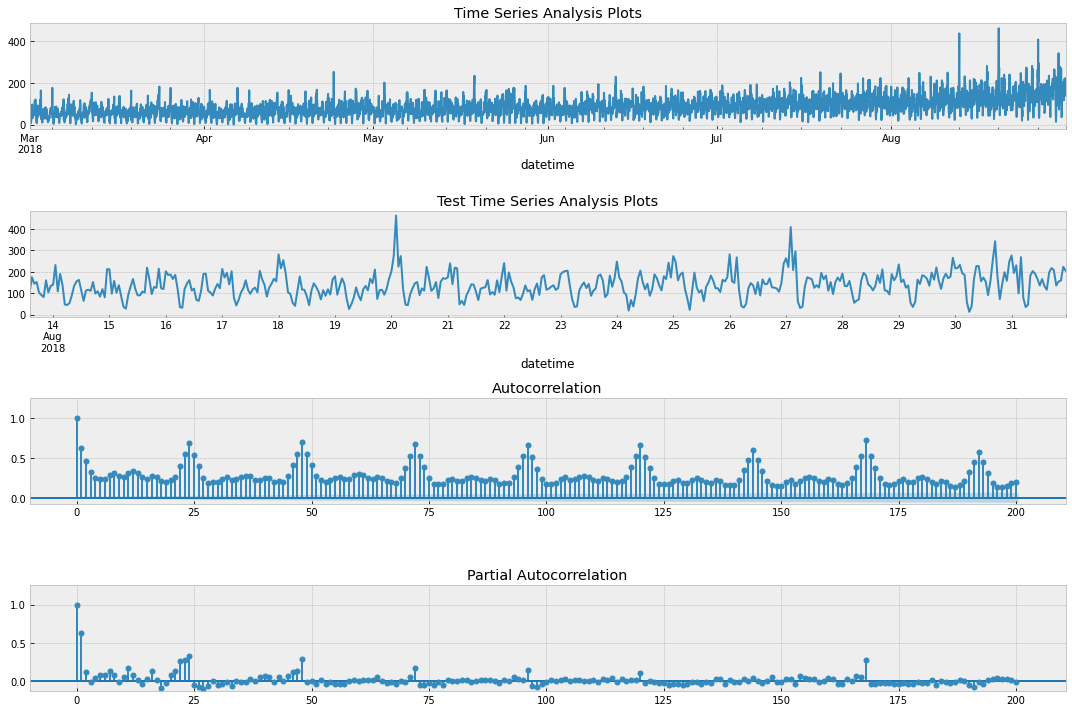

In [4]:
with plt.style.context('bmh'):
    f, axs = plt.subplots(4, 1, figsize=(15, 10))
    df.num_orders.plot(ax=axs[0]).set_title('Time Series Analysis Plots')
    df.num_orders[test_limit:].plot(ax=axs[1]).set_title('Test Time Series Analysis Plots')
    smt.graphics.plot_acf(df.num_orders, lags=200, ax=axs[2], alpha=0.5, auto_ylims=True)
    smt.graphics.plot_pacf(df.num_orders, lags=200, ax=axs[3], alpha=0.5, method='ywm', auto_ylims=True)
    plt.tight_layout()

Высокая ежедневная корреляция и недельная сезонность.

## Моделирование

За точку отсчета возьмем предсказание равное количеству заказов за предыдущий час

In [5]:
print('Based Dummy`s prediction RMSE:')
display(np.round(mean_squared_error(df['num_orders'][test_limit:],
                                    df['num_orders'].shift()[test_limit:],
                                    squared=False),2))

Based Dummy`s prediction RMSE:


58.86

Обучим авторегрессор на данных

In [ ]:
ar = []
for n in range(test_limit, len(df)):
    print(n)
    model = AutoReg(df['num_orders'][:n],
                    lags=167,
                    seasonal=True,
                    period=168).fit()
    ar.append(model.predict(n,n).values[0])

In [8]:
df['num_orders'][:3455]

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-07-22 18:00:00     52
2018-07-22 19:00:00     55
2018-07-22 20:00:00     99
2018-07-22 21:00:00    104
2018-07-22 22:00:00    105
Freq: H, Name: num_orders, Length: 3455, dtype: int64

Оценим ошибку

In [7]:
print('Autoregression`s  prediction RMSE:')
display(np.round(mean_squared_error(df['num_orders'][test_limit:],
                                    ar,
                                    squared=False),2))

Autoregression`s  prediction RMSE:


35.06

Что соответсвует изначальным требованиям

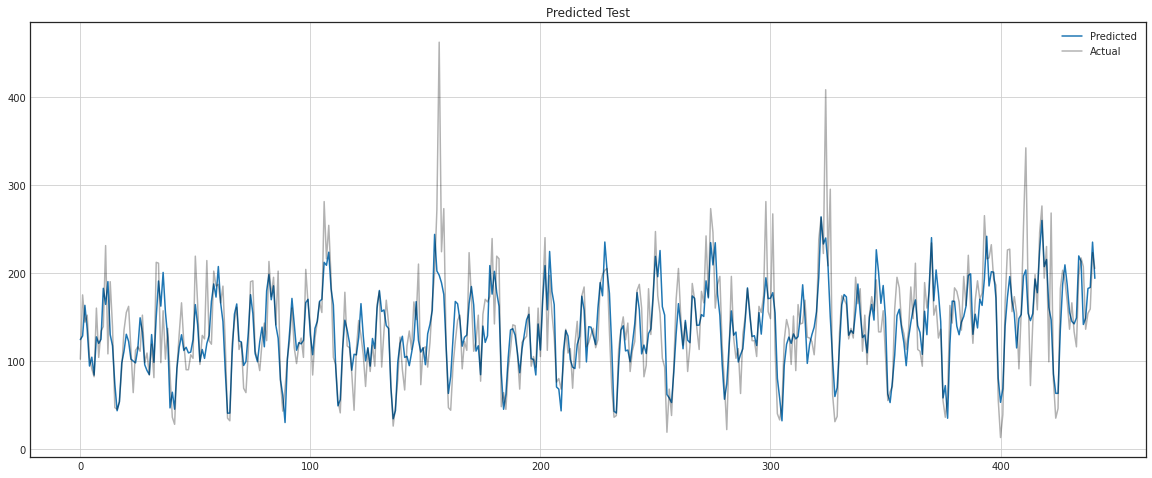

In [8]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    plt.plot(ar, label = "Predicted")
    plt.plot(df.num_orders[test_limit:].values, "k", label = "Actual", alpha=0.3)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Predicted Test")
    plt.grid(True)

Основная доля ошибок выпадает на аномально резкие увеличения спроса

## Выводы

1. Построена Autoregression модель, которая соответсвует требуемой точности.
2. Основная часть ошибок модели приходится на аномальные всплески, которые вероятно связаны с внешними факторами (погода, форс мажор и др.) информации о которых нет в исходных данных